In [ ]:
# Standard library
import string
from pathlib import Path

# Scientific & data handling
import numpy as np
import pandas as pd
import xarray as xr

# Geospatial libraries
import geopandas as gpd
import shapely
from shapely import wkt
from shapely.geometry import Point, mapping

# Raster & vector operations
from rasterio import features
from rasterio.features import geometry_mask
from affine import Affine

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import (
    ListedColormap,
    BoundaryNorm
)
import matplotlib.patches as mpatches

# Mapping
import contextily as cx 

# 1. Future Flooding

In [ ]:
# Define scenarios and bins
scenarios = ["15", "20", "30", "40"]
scenario_labels = {"15": "1.5", "20": "2.0", "30": "3.0", "40": "4.0"}  # for titles
bins = [10, 25, 50, 100, 150, np.inf]
labels = ["10-25", "25-50", "50-100", "100-150", "150+"]
colors = ["#b2182b", "#ef8a62", "#fddbc7","#d1e5f0", "#67a9cf"]
color_dict = dict(zip(labels, colors))
color_dict["No data"] = "white"

In [ ]:
BASE_DIR = Path.cwd().parent
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"
intermediate_results_path = BASE_DIR / 'intermediate_results'

In [ ]:
basins = pd.read_csv(intermediate_results_path / "SRB_flood_statistics_per_Basin_basins_scenario.csv")

all_basins = gpd.read_file(data_path / "hybas_eu_lev09_v1c.shp")
basins = gpd.GeoDataFrame(basins.merge(all_basins,left_on='basinID',right_on='HYBAS_ID'))

# --- Open NetCDF dataset ---
ds = xr.open_dataset(data_path / "disEnsemble_highExtremes.nc")

# Attach CRS (Lambert Azimuthal Equal Area)
ds = ds.rio.write_crs("EPSG:3035", inplace=False)
print("Raster CRS:", ds.rio.crs)

roads = gpd.read_parquet(intermediate_results_path / "PERS_directed_final.parquet")

if roads.crs != "EPSG:3035":
    roads = roads.to_crs("EPSG:3035")

Raster CRS: EPSG:3035


In [ ]:
# --- Prepare a dictionary to hold all scenarios (both % change and RP shift) ---
rl_dict = {}

for scenario in scenarios:
    # Percent change (already done)
    da = ds[f"return_level_perc_chng_{scenario}"]
    sig = ds[f"significant_{scenario}"]
    da = da.where(sig == 1)
    da = da.transpose("y", "x").sortby("y")
    da = da.rio.write_crs("EPSG:3035", inplace=False)
    da = da.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)
    rl_dict[f"perc_chng_{scenario}"] = da

    # Return period shift
    rp = ds[f"baseline_rp_shift_{scenario}"]
    rp = rp.transpose("y", "x").sortby("y")
    rp = rp.rio.write_crs("EPSG:3035", inplace=False)
    rp = rp.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)
    rl_dict[f"rp_shift_{scenario}"] = rp


In [ ]:
for scenario in scenarios:
    da = ds[f"return_level_perc_chng_{scenario}"]
    sig = ds[f"significant_{scenario}"]

    # Mask non-significant values
    da = da.where(sig == 1)

    # Transpose and sort to match typical raster orientation
    da = da.transpose("y", "x").sortby("y")

    # Attach CRS and spatial dims
    da = da.rio.write_crs("EPSG:3035", inplace=False)
    da = da.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)

    rl_dict[scenario] = da

In [ ]:
# --- Reproject basins to raster CRS ---
basins_3035 = basins.to_crs(rl_dict["30"].rio.crs)  # use any scenario's CRS, all are the same

print("Basins reprojected to raster CRS:", basins_3035.crs)

Basins reprojected to raster CRS: PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]


In [ ]:
print("calculate new return period of floods that historically had a return period of 100 years")
# Loop over scenarios and calculate basin means
for scenario in scenarios:
    print(f"Processing warming scenario of {scenario_labels[scenario]}°C...")

    # Select the DataArray for this scenario
    da = rl_dict[f"rp_shift_{scenario}"]


    # Clip and calculate mean per basin
    mean_vals = []
    for _, basin in basins_3035.iterrows():
        masked = da.rio.clip([basin.geometry], basins_3035.crs, drop=False)
        vals = masked.values
        vals = vals[~np.isnan(vals)]
        mean_vals.append(vals.mean() if vals.size else np.nan)

    # Save results in basins_3035
    basins_3035[f"rp{scenario}_mean"] = mean_vals

    # Print min/max to adjust bins
    min_val = np.nanmin(mean_vals)
    max_val = np.nanmax(mean_vals)
    print(f"Shortest new return period={min_val:.2f}, longest new return period={max_val:.2f} (years)")

Processing scenario 15...
Scenario 15: min=39.88, max=104.98
Processing scenario 20...
Scenario 20: min=25.34, max=126.22
Processing scenario 30...
Scenario 30: min=13.42, max=117.43
Processing scenario 40...
Scenario 40: min=12.38, max=317.45


In [ ]:
for scenario in scenarios:
    col_mean = f"rp{scenario}_mean"

    # Categorize into bins
    basins_3035[f"rp{scenario}_bin"] = pd.cut(
        basins_3035[col_mean],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    # Count basins per bin
    bin_counts = basins_3035[f"rp{scenario}_bin"].value_counts().sort_index()
    no_data_count = basins_3035[f"rp{scenario}_bin"].isna().sum()

    print(f"Scenario {scenario} ({scenario_labels[scenario]}°C):")
    print("Number of basins in each bin:")
    print(bin_counts)
    print(f"Number of basins with no data: {no_data_count}\n")


# Drop leftover spatial join columns if they exist
roads = roads.drop(
    columns=[c for c in ["index_right", "index_left"] if c in roads.columns],
    errors="ignore"
)

basins_3035 = basins_3035.drop(
    columns=[c for c in ["index_right", "index_left"] if c in basins_3035.columns],
    errors="ignore"
)

# Start from roads
roads_rp = roads.copy()

# One spatial join (no scenario-specific columns yet)
roads_rp = gpd.sjoin(
    roads_rp,
    basins_3035[["geometry"] + [f"rp{s}_mean" for s in scenarios]],
    how="left",
    predicate="intersects"
)

# Create bins for each scenario
for scenario in scenarios:
    roads_rp[f"rp{scenario}_bin"] = pd.cut(
        roads_rp[f"rp{scenario}_mean"],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    print(f"Scenario {scenario} — roads mean:")
    print(roads_rp[f"rp{scenario}_mean"].describe())
    print("ROADS BIN")
    print(roads_rp[f"rp{scenario}_bin"].value_counts(dropna=False))

Scenario 15 (1.5°C):
Number of basins in each bin:
rp15_bin
10-25        0
25-50       40
50-100     166
100-150      1
150+         0
Name: count, dtype: int64
Number of basins with no data: 94

Scenario 20 (2.0°C):
Number of basins in each bin:
rp20_bin
10-25        0
25-50       89
50-100     117
100-150      1
150+         0
Name: count, dtype: int64
Number of basins with no data: 94

Scenario 30 (3.0°C):
Number of basins in each bin:
rp30_bin
10-25       32
25-50      117
50-100      56
100-150      2
150+         0
Name: count, dtype: int64
Number of basins with no data: 94

Scenario 40 (4.0°C):
Number of basins in each bin:
rp40_bin
10-25       18
25-50      116
50-100      66
100-150      4
150+         3
Name: count, dtype: int64
Number of basins with no data: 94

Scenario 15 — roads mean:
count    6107.000000
mean       60.580052
std        11.175198
min        39.878979
25%        51.110146
50%        60.301010
75%        69.765610
max       104.976639
Name: rp15_mean, dtype

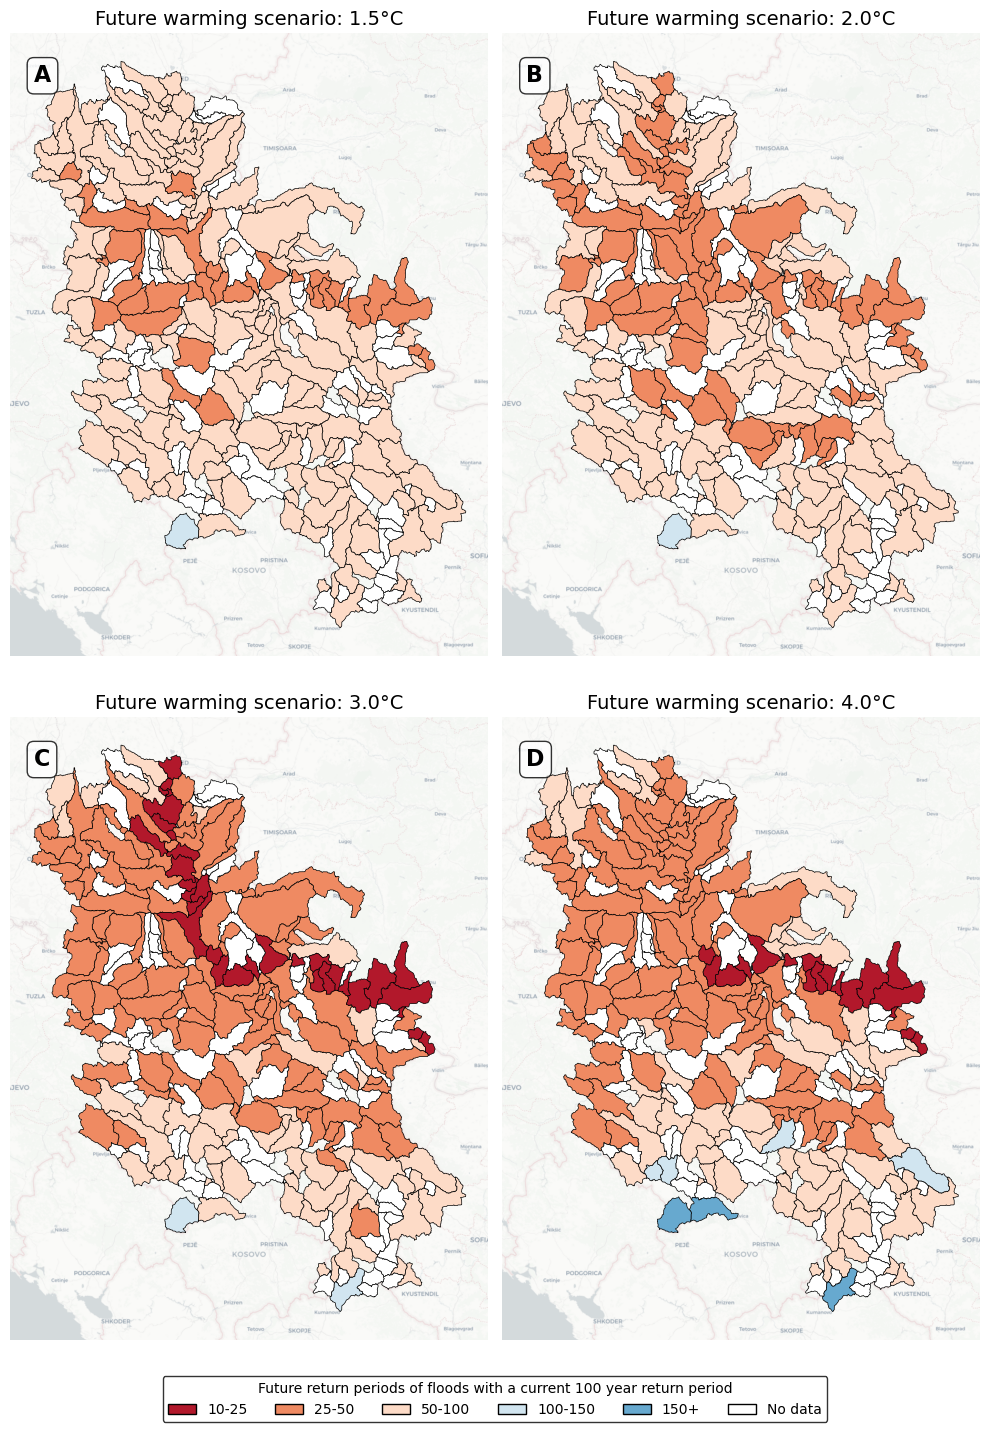

In [ ]:

#############################################
# Plot basins
#############################################


# Reproject basins to Web Mercator for basemap
basins_3857 = basins_3035.to_crs(epsg=3857)

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 14.5))
axes = axes.flatten()

for i, scenario in enumerate(scenarios):
    col_mean = f"rp{scenario}_mean"

    # Categorize into bins
    basins_3857[f"rp{scenario}_bin"] = pd.cut(
        basins_3857[col_mean],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    # Create plot color column, assign white to NaN
    basins_3857[f"plot_color_{scenario}"] = basins_3857[f"rp{scenario}_bin"].astype(str)
    basins_3857.loc[basins_3857[f"plot_color_{scenario}"] == "nan", f"plot_color_{scenario}"] = "No data"
    basins_3857[f"plot_color_{scenario}"] = basins_3857[f"plot_color_{scenario}"].map(color_dict)

    # Plot basins
    basins_3857.plot(
        color=basins_3857[f"plot_color_{scenario}"],
        edgecolor="black",
        linewidth=0.5,
        ax=axes[i]
    )

    # Add basemap
    cx.add_basemap(
        ax=axes[i],
        source=cx.providers.CartoDB.Positron,
        alpha=1.0,
        attribution=False
    )

    axes[i].set_title(f"Future warming scenario: {scenario_labels[scenario]}°C", fontsize=14)
    axes[i].set_axis_off()

# Create shared legend
handles = [mpatches.Patch(facecolor=color_dict[label], edgecolor="black", label=label) for label in labels + ["No data"]]
fig.legend(
    handles=handles,
    title="Future return periods of floods with a current 100 year return period",
    loc="lower center",
    ncol=len(handles),
    frameon=True,                # box around legend
    edgecolor="black",
    facecolor="white"
)



labels = string.ascii_uppercase
N = 4  # number of plots used

# Flatten axes in any order
axes_flat = axes.flatten()  

# Sort axes **top-to-bottom, left-to-right**
axes_sorted = sorted(
    axes_flat[:N],
    key=lambda ax: (-ax.get_position().y0, ax.get_position().x0)  # negative y0 for top-to-bottom
)

# Add labels
for i, ax in enumerate(axes_sorted):
    ax.text(
        0.05, 0.95, labels[i],
        transform=ax.transAxes,
        fontsize=16,
        fontweight='bold',
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
    )


plt.tight_layout(rect=[0, 0.03, 1, 1])  # leave space at bottom for legend
plt.savefig(figure_path / "Change in return period.png", dpi=300, bbox_inches="tight")
basins_3857.to_parquet(intermediate_results_path / "Future Floods change in RP.parquet")
plt.show()

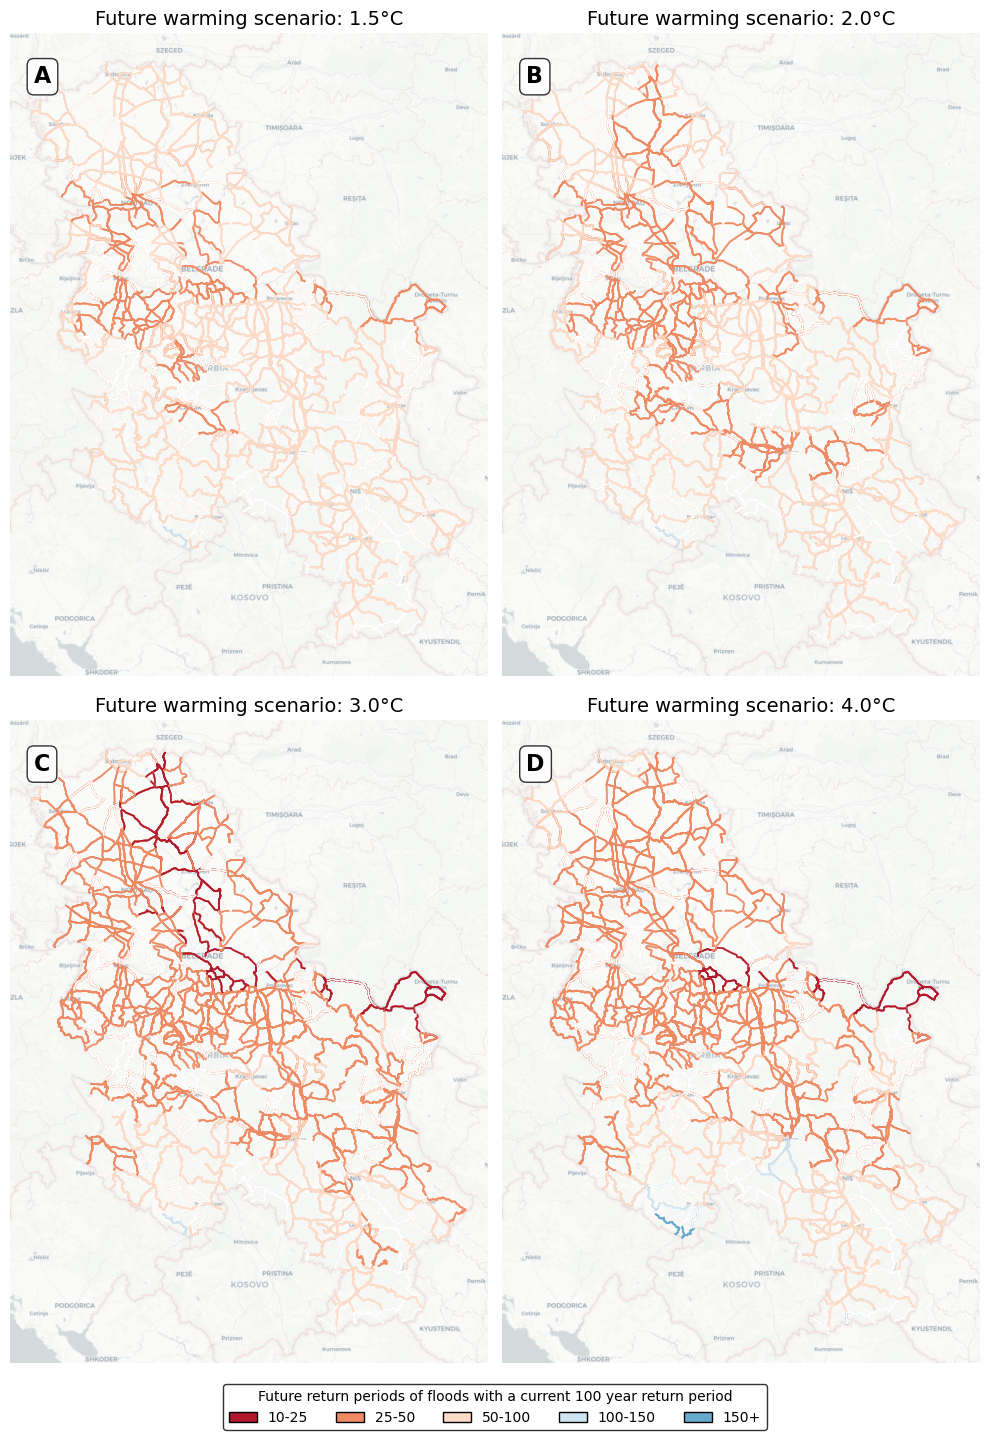

In [ ]:

#############################################
# Plot effect on roads
#############################################


# Reproject basins to Web Mercator for basemap
roads_rp = roads_rp.to_crs(epsg=3857)
# Reproject basins to Web Mercator for basemap
roads = roads.to_crs(epsg=3857)

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 14.5))
axes = axes.flatten()

for i, scenario in enumerate(scenarios):
    col_mean = f"rp{scenario}_mean"


    # Create plot color column, assign white to NaN
    roads_rp[f"plot_color_{scenario}"] = roads_rp[f"rp{scenario}_bin"].astype(str)
    roads_rp.loc[roads_rp[f"plot_color_{scenario}"] == "nan", f"plot_color_{scenario}"] = "No data"
    roads_rp[f"plot_color_{scenario}"] = roads_rp[f"plot_color_{scenario}"].map(color_dict)

    #plot roads in the background in grey 
    roads.plot(
            ax=axes[i],
            color="grey",
            linewidth=0.8
        )

    # Plot roads that experience change
    roads_rp.plot(
        color=roads_rp[f"plot_color_{scenario}"],
        edgecolor="black",
        linewidth=1.2,
        ax=axes[i]
    )

    # Add basemap
    cx.add_basemap(
        ax=axes[i],
        source=cx.providers.CartoDB.Positron,
        alpha=1.0,
        attribution=False
    )

    axes[i].set_title(f"Future warming scenario: {scenario_labels[scenario]}°C", fontsize=14)
    axes[i].set_axis_off()

# Create shared legend
#legend_labels = ["-10-0", "0-10", "10-25", "25-50", "50+", "No data"]
legend_labels = ["10-25", "25-50", "50-100", "100-150", "150+"]

handles = [
    mpatches.Patch(
        facecolor=color_dict[label],
        edgecolor="black",
        label=label
    )
    for label in legend_labels
]

fig.legend(
    handles=handles,
    title="Future return periods of floods with a current 100 year return period",
    loc="lower center",
    ncol=len(handles),
    frameon=True,                # box around legend
    edgecolor="black",
    facecolor="white"
)


labels = string.ascii_uppercase
N = 4  # number of plots used

# Flatten axes in any order
axes_flat = axes.flatten()  

# Sort axes **top-to-bottom, left-to-right**
axes_sorted = sorted(
    axes_flat[:N],
    key=lambda ax: (-ax.get_position().y0, ax.get_position().x0)  # negative y0 for top-to-bottom
)

# Add labels
for i, ax in enumerate(axes_sorted):
    ax.text(
        0.05, 0.95, labels[i],
        transform=ax.transAxes,
        fontsize=16,
        fontweight='bold',
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
    )


plt.tight_layout(rect=[0, 0.03, 1, 1])  # leave space at bottom for legend
plt.savefig(figure_path / "Change in return period experienced by roads.png", dpi=300, bbox_inches="tight")
roads_rp.to_parquet(intermediate_results_path / "Future Floods change in RP experienced by roads.parquet")
plt.show()

# 2. Future heavy precipitation

In [ ]:
def max_raster_along_line(line, raster, transform):
    """
    Returns the maximum raster value intersecting a line geometry.
    """
    mask = geometry_mask(
        [mapping(line)],
        transform=transform,
        invert=True,
        out_shape=raster.shape
    )

    values = raster[mask]

    if np.all(np.isnan(values)):
        return np.nan

    return np.nanmax(values)

In [ ]:
# Load dataset and calculate future precipitation changes

results = {}

for rcp in ("45", "85"):
    results[rcp] = {}
    for period in ("1", "2"):

        file_name = r"Climate Change Precipitation\results\rcp" + rcp + "_rx1d_change" + period + ".nc"
        file = data_path / file_name
        
        ds = xr.open_dataset(
            file
        )

        file_name = r"Climate Change Precipitation\results\rcp" + rcp + "_rx1d_change" + period + "_ensmed.nc"
        file_name_ensamble = data_path / file_name
        ensamble_median = xr.open_dataset(
            file_name_ensamble
        )

        roads = gpd.read_parquet(intermediate_results_path / "PERS_directed_final.parquet")

        if roads.crs != "EPSG:4326":
            roads = roads.to_crs("EPSG:4326")



        if rcp == "45":
            rcp_text = "4.5"
        elif rcp == "85":
            rcp_text = "8.5"

        if period == "1":
            period_text = "2031-2060"
        elif rcp == "2":
            period_text = "2071-2100"

        # -----------------------------
        # Load Serbia boundary
        # -----------------------------
        url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
        world = gpd.read_file(url)
        serbia = world[world.NAME == "Serbia"]

        # -----------------------------
        # Set CRS for dataset
        # -----------------------------
        ds = ds.rio.write_crs("EPSG:4326")
        ds = ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")

        ensamble_median = ensamble_median.rio.write_crs("EPSG:4326")
        ensamble_median = ensamble_median.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")

        #make variable names consistent with baseline data
        ensamble_median = ensamble_median.rename({
            "Change_ensmed_T20":   "Change_T20",
            "Change_ensmed_T50":   "Change_T50",
            "Change_ensmed_T100":  "Change_T100",
            "Change_ensmed_T500":  "Change_T500",
            "Change_ensmed_T1000": "Change_T1000",
        })


        # -----------------------------
        # Variables to plot
        # -----------------------------

        variables = ["Change_T20",] #in data set: "Change_T20","Change_T50","Change_T100","Change_T500","Change_T1000",


        # -----------------------------
        # Plot setup
        # -----------------------------

        for var in variables:

            data = ds[var]
            ensemble = ensamble_median[var]

            # Count positive & negative models
            n_pos = (data > 0).sum(dim="model")
            n_neg = (data < 0).sum(dim="model")

            # Agreement classification
            agreement = xr.zeros_like(n_pos)

            # Negative agreement
            agreement = xr.where(n_neg == 8, -4, agreement)
            agreement = xr.where(n_neg == 7, -3, agreement)
            agreement = xr.where(n_neg == 6, -2, agreement)
            agreement = xr.where(n_neg == 5, -1, agreement)

            # Positive agreement
            agreement = xr.where(n_pos == 5,  1, agreement)
            agreement = xr.where(n_pos == 6,  2, agreement)
            agreement = xr.where(n_pos == 7,  3, agreement)
            agreement = xr.where(n_pos == 8,  4, agreement)

            # -----------------------------
            # Build affine transform
            # -----------------------------
            lon = agreement.longitude.values
            lat = agreement.latitude.values

            transform = (
                Affine.translation(lon[0], lat[0])
                * Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
            )

            # -----------------------------
            # Rasterize Serbia mask
            # -----------------------------
            mask = features.rasterize(
                [(geom, 1) for geom in serbia.geometry],
                out_shape=(len(lat), len(lon)),
                transform=transform,
                fill=0,
                dtype="uint8",
            )

            mask = xr.DataArray(
                mask,
                coords={"latitude": lat, "longitude": lon},
                dims=("latitude", "longitude"),
            )

            # Apply mask
            agreement_clip = agreement.where(mask == 1)

            # -----------------------------
            # Agreement percentage
            # -----------------------------
            total_cells = agreement_clip.count().item()
            good_cells = agreement_clip.where(agreement_clip != 0).count().item()
            percent_good = good_cells / total_cells * 100

            ensemble_masked = ensemble.where(agreement != 0)

            lon = ensemble.longitude.values
            lat = ensemble.latitude.values

            transform = (
                Affine.translation(lon[0], lat[0])
                * Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
            )
            

            mask = features.rasterize(
                [(geom, 1) for geom in serbia.geometry],
                out_shape=(len(lat), len(lon)),
                transform=transform,
                fill=0,
                dtype="uint8",
            )

            mask = xr.DataArray(
                mask,
                coords={"latitude": lat, "longitude": lon},
                dims=("latitude", "longitude"),
            )

            ensemble_masked = ensemble_masked.where(mask == 1)

            #convert to percent
            ensemble_masked_pct  = ensemble_masked * 100

            # Use percent-scaled, agreement-masked data
            raster = ensemble_masked_pct

            # Extract values
            raster_values = raster.values

            # Build affine transform
            lon = raster.longitude.values
            lat = raster.latitude.values

            transform = Affine.translation(lon[0], lat[0]) * Affine.scale(
                lon[1] - lon[0], lat[1] - lat[0]
            )

            roads["max_rx1day_pct"] = roads.geometry.apply(
                lambda geom: max_raster_along_line(
                    geom,
                    raster_values,
                    transform
                )
            )

            #roads_climate = roads.dropna(subset=["max_rx1day_pct"])
            roads_with_agreement = roads[roads["max_rx1day_pct"].notna()]
            roads_no_agreement = roads[roads["max_rx1day_pct"].isna()]

            results[rcp][period] = {
                "roads_with_agreement": roads_with_agreement,
                "no_agreement": roads_no_agreement,
            }

            #save result per rcp and time period 
            file_name = "change in maximum daily precipitation rcp " + rcp + " period "+ period + ".paquet"
            file_text = intermediate_results_path / file_name
            roads_with_agreement.to_parquet(file_text)


min value in rcp  45 period  1
-4.6401214599609375
max value in rcp  45 period  1
11.674826622009277
Total roads (45, 1): 5490
bin
(-10, -5]       0
(-5, -2]      339
(-2, 0]       260
(0, 2]        549
(2, 5]       1660
(5, 10]      1857
(10, 15]      125
(15, 20]        0
(20, 25]        0
dtype: int64


C:\Users\yma794\AppData\Local\Temp\ipykernel_11916\1516538537.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


min value in rcp  85 period  1
-4.892272472381592
max value in rcp  85 period  1
18.106321334838867
Total roads (85, 1): 5490
bin
(-10, -5]       0
(-5, -2]       25
(-2, 0]       131
(0, 2]        428
(2, 5]       1525
(5, 10]      1980
(10, 15]      621
(15, 20]      127
(20, 25]        0
dtype: int64


C:\Users\yma794\AppData\Local\Temp\ipykernel_11916\1516538537.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


min value in rcp  45 period  2
-5.628530025482178
max value in rcp  45 period  2
14.977174758911133
Total roads (45, 2): 5490
bin
(-10, -5]       6
(-5, -2]       20
(-2, 0]       267
(0, 2]        315
(2, 5]       1819
(5, 10]      2269
(10, 15]      119
(15, 20]        0
(20, 25]        0
dtype: int64


C:\Users\yma794\AppData\Local\Temp\ipykernel_11916\1516538537.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


min value in rcp  85 period  2
-1.0411498546600342
max value in rcp  85 period  2
20.81479835510254
Total roads (85, 2): 5490
bin
(-10, -5]       0
(-5, -2]        0
(-2, 0]        52
(0, 2]         65
(2, 5]       1233
(5, 10]      2469
(10, 15]     1088
(15, 20]      291
(20, 25]       16
dtype: int64


C:\Users\yma794\AppData\Local\Temp\ipykernel_11916\1516538537.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


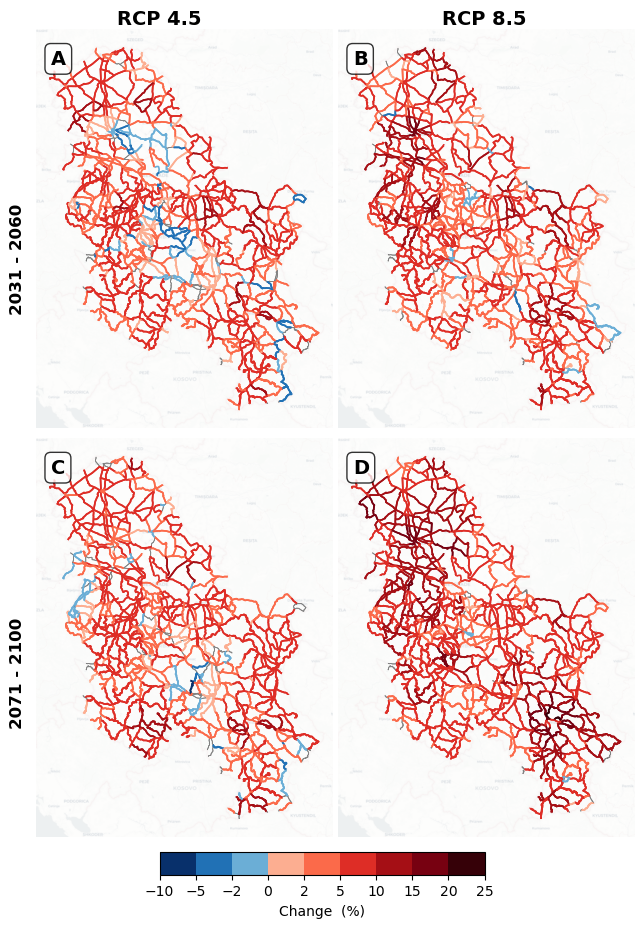

In [ ]:

################################
# Plot the results
###############################

rcps = ["45", "85"]
periods = ["1", "2"] 

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(6.5, 9.2),
    sharex=True, sharey=True    
)

fig.subplots_adjust(
    left=0.06,    # left margin
    right=0.98,   # right margin
    top=0.98,     # top margin
    bottom=0.10,  # leave room for colorbar
    wspace=0.02,  # horizontal space between subplots
    hspace=0.02   # vertical space between subplots
)

labels = string.ascii_uppercase
N = 4  # number of plots used

# Flatten axes in any order
axes_flat = axes.flatten()  

# Sort axes **top-to-bottom, left-to-right**
axes_sorted = sorted(
    axes_flat[:N],
    key=lambda ax: (-ax.get_position().y0, ax.get_position().x0)  # negative y0 for top-to-bottom
)

# Add labels
for i, ax in enumerate(axes_sorted):
    ax.text(
        0.05, 0.95, labels[i],
        transform=ax.transAxes,
        fontsize=14,
        fontweight='bold',
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
    )

    

for row, period in enumerate(periods):
    for col, rcp in enumerate(rcps):

        #reproject to match contextily
        results[rcp][period]["roads_with_agreement"] = (
            results[rcp][period]["roads_with_agreement"]
            .to_crs(epsg=3857)
        )

        results[rcp][period]["no_agreement"] = (
            results[rcp][period]["no_agreement"]
            .to_crs(epsg=3857)
        )

        ax = axes[row, col]

        # plot roads without agreement (grey, underneath)
        results[rcp][period]["no_agreement"].plot(
            ax=ax,
            color="grey",
            linewidth=0.6
        )

        print("min value in rcp ", rcp, "period ", period)
        print(results[rcp][period]["roads_with_agreement"]["max_rx1day_pct"].min())
        print("max value in rcp ", rcp, "period ", period)
        print(results[rcp][period]["roads_with_agreement"]["max_rx1day_pct"].max())

        total_roads = (
            len(results[rcp][period]["roads_with_agreement"]) +
            len(results[rcp][period]["no_agreement"])
        )

        print(f"Total roads ({rcp}, {period}):", total_roads)

        bins = [-10, -5, -2, 0, 2, 5, 10, 15, 20, 25]

        gdf = results[rcp][period]["roads_with_agreement"]

        counts = (
            gdf
            .assign(bin=pd.cut(gdf["max_rx1day_pct"], bins=bins))
            .groupby("bin")
            .size()
        )

        print(counts)

        colors = [
            "#08306b",  # strong decrease (dark blue)
            "#2171b5",  # moderate decrease
            "#6baed6",  # slight decrease (light blue)
            "#fcae91",  # small increase (light red)
            "#fb6a4a",  # moderate increase
            "#de2d26",  # strong increase
            "#a50f15",  # very strong increase
            "#770111",   # extreme increase
            "#360108"
        ]

        cmap = ListedColormap(colors)
        norm = BoundaryNorm(bins, cmap.N)

        # plot roads with signal (coloured)
        results[rcp][period]["roads_with_agreement"].plot(
            ax=ax,
            column="max_rx1day_pct",
            norm=norm,
            cmap = cmap,
            linewidth=1.2,
            legend = False,
            legend_kwds={"label": "Max RX1day change (%)"}
        )

        #colorbar
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])


        ax.set_axis_off()

        # Add basemap
        cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, 
                   alpha=0.4, attribution=False)



rcps_tite = ["4.5", "8.5"]
periods_title = ["2031 - 2060", "2071 - 2100"]

# Column titles
for col, rcp in enumerate(rcps_tite):
    # Position: x in figure coordinates, y at top of subplots (1 = top)
    x = 0.25 if col == 0 else 0.75  # tweak depending on layout
    fig.text(
        x, 0.98,  # slightly above top
        f"RCP {rcp}",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold"
    )

# Row titles
for row, period in enumerate(periods_title):
    # Position: y in figure coordinates, x at left of subplots
    y = 0.73 if row == 0 else 0.28  # tweak depending on layout
    fig.text(
        0.02, y,
        period,
        ha="left",
        va="center",
        fontsize=12,
        rotation=90,
        fontweight="bold"
    )
        
cax = fig.add_axes([0.25, 0.06, 0.5, 0.025])

cbar = fig.colorbar(
    sm,
    cax=cax,
    orientation="horizontal"
)

cbar.set_label("Change  (%)")
cbar.set_ticks(bins)
for ax in axes.flat:
    ax.margins(0)


plt.savefig(figure_path / "change in Rx1d.png", dpi=300, bbox_inches="tight")
plt.show()